# Gaussian Mixture Model Training on Spiral Data

This tutorial demonstrates how to train a diagonal Gaussian mixture model on spiral data using forward KL divergence (maximum likelihood estimation). This serves as a basic training example showing the core patterns used in bijx for training probability distributions.

Unlike the continuous flow examples, this tutorial focuses on directly training a parametric distribution (GMM) without bijective transformations, making it a good starting point for understanding the training patterns in bijx.
The model can easily be replaced or extended with further bijection layers.

In [ ]:
import flax.nnx as nnx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
from tqdm import tqdm

import bijx

# define a random number sequence for convenience
rngs = nnx.Rngs(0)

## Data Generation

First, let's create a function to generate 2D spiral data. This will serve as our target distribution that we want the GMM to learn.

In [ ]:
def generate_spiral_data(n_samples=1000, noise=0.02, seed=42):
    """Generate 2D spiral data."""
    rng = np.random.RandomState(seed)
    t = 5 * rng.rand(n_samples) * np.pi
    x = t * np.cos(t) / 20
    y = t * np.sin(t) / 20
    # Add noise
    x += noise * rng.randn(n_samples)
    y += noise * rng.randn(n_samples)
    return jnp.stack([x, y], axis=1)

In [ ]:
def plot_data_and_model(data, model, title="Data and Model", figsize=(12, 4)):
    """Plot the data and model density/samples."""
    plt.figure(figsize=figsize)

    # Plot original data
    plt.subplot(1, 3, 1)
    plt.scatter(data[:, 0], data[:, 1], alpha=0.5, s=10)
    plt.title("Original Data")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')

    # Plot model samples
    plt.subplot(1, 3, 2)
    samples, _ = model.sample(batch_shape=(len(data),))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, s=10, color='orange')
    plt.title("Model Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.axis('equal')

    # Plot model density
    plt.subplot(1, 3, 3)
    # Create grid for density evaluation
    x_range = [data[:, 0].min() - 0.5, data[:, 0].max() + 0.5]
    y_range = [data[:, 1].min() - 0.5, data[:, 1].max() + 0.5]
    x_grid, y_grid = jnp.mgrid[
        x_range[0]:x_range[1]:100j,
        y_range[0]:y_range[1]:100j
    ]
    grid_points = jnp.stack([x_grid.ravel(), y_grid.ravel()], axis=1)

    # Evaluate density
    log_densities = model.log_density(grid_points).reshape(x_grid.shape)

    plt.imshow(
        log_densities.T,
        extent=[x_range[0], x_range[1], y_range[0], y_range[1]],
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    plt.colorbar(label='Log density')
    plt.title("Model Density")
    plt.xlabel("x")
    plt.ylabel("y")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

## Configuration and Data Generation

Let's set up our training configuration and generate the spiral data.

In [ ]:
# Configuration
n_components = 64
n_samples = 1000
n_epochs = 50  # Reduced for faster execution
batch_size = 128
learning_rate = 1e-2

Data shape: (1000, 2), range: [-0.80, 0.75]


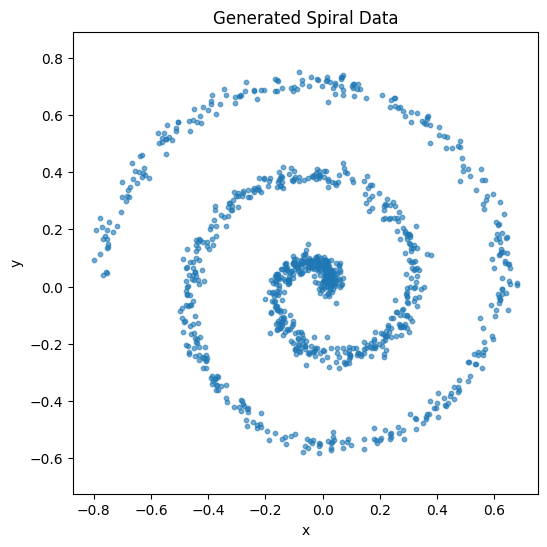

In [ ]:
# Generate spiral data
data = generate_spiral_data(n_samples=n_samples, noise=0.02, seed=42)
print(f"Data shape: {data.shape}, range: [{data.min():.2f}, {data.max():.2f}]")

# Visualize the data
plt.figure(figsize=(6, 6))
plt.scatter(data[:, 0], data[:, 1], alpha=0.6, s=10)
plt.title("Generated Spiral Data")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

## Model Creation

Now let's create the diagonal Gaussian mixture model using the new `GaussianMixture` class from bijx. We'll initialize the component means, variances, and mixture weights.

In [ ]:
# Create diagonal Gaussian mixture model
print(f"Creating diagonal GMM with {n_components} components...")

# Initialize means and variances for the mixture components
means_init = jax.random.normal(rngs(), (n_components, 2)) * 0.5
scales_init = jnp.ones((n_components, 2)) * 0.5
weights_init = jnp.zeros(n_components)  # Will be normalized via softmax

# Create the Gaussian mixture model
gmm = bijx.GaussianMixture(
    means=means_init,
    covariances=scales_init**2,  # DiagonalNormal expects variances
    weights=weights_init,
    rngs=rngs
)

print(f"Model created with {n_components} components")
print(f"Initial means shape: {means_init.shape}")
print(f"Initial scales shape: {scales_init.shape}")

Creating diagonal GMM with 64 components...
Model created with 64 components
Initial means shape: (64, 2)
Initial scales shape: (64, 2)


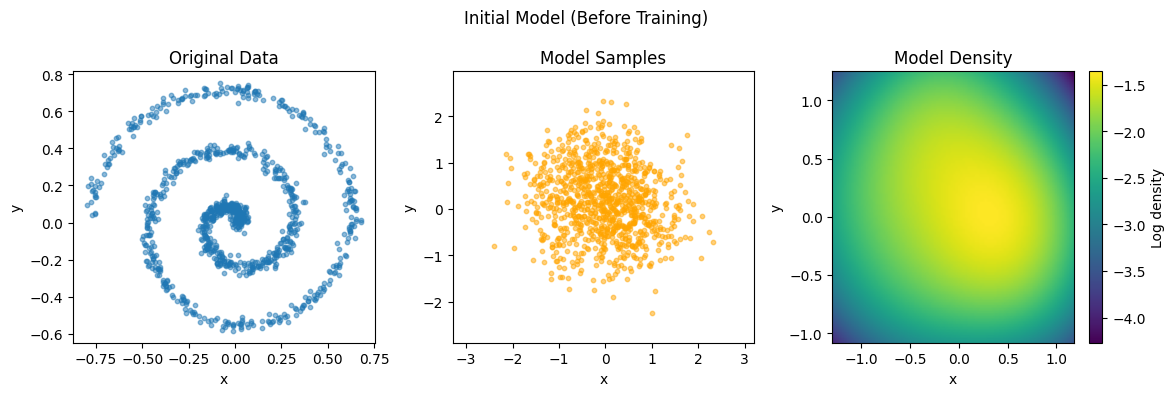

In [ ]:
# Plot initial model
plot_data_and_model(data, gmm, "Initial Model (Before Training)")

## Training Setup

Now let's set up the optimization. We'll use forward KL divergence (maximum likelihood) as our objective, which means we want to minimize the negative log-likelihood of the data under our model.

The loss function is: $L = -\mathbb{E}_{x \sim \text{data}}[\log p_{\theta}(x)]$

where $p_{\theta}(x)$ is our GMM density.

In [ ]:
# Set up optimization
optimizer = nnx.Optimizer(
    gmm,
    optax.adam(learning_rate),
    wrt=nnx.Param,
)

@nnx.jit
def training_step(model, optimizer, batch):
    """Single training step using forward KL (maximum likelihood)."""
    def loss_fn(model):
        # Forward KL: minimize -log p(x) = minimize negative log-likelihood
        log_probs = model.log_density(batch)
        return -jnp.mean(log_probs)

    loss, grads = nnx.value_and_grad(loss_fn)(model)
    optimizer.update(grads=grads, model=model)
    return loss

## Training Loop

Now let's run the training loop. We'll use mini-batch stochastic gradient descent with shuffling.

In [ ]:
# Training loop
print(f"Starting training for {n_epochs} epochs...")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")

losses = []
n_batches = len(data) // batch_size

# Create batches
key = jax.random.PRNGKey(42)

for epoch in tqdm(range(n_epochs), desc="Training"):
    epoch_losses = []

    # Shuffle data each epoch
    key, subkey = jax.random.split(key)
    indices = jax.random.permutation(subkey, len(data))
    shuffled_data = data[indices]

    # Process batches
    for i in range(n_batches):
        batch_start = i * batch_size
        batch_end = min((i + 1) * batch_size, len(data))
        batch = shuffled_data[batch_start:batch_end]

        loss = training_step(gmm, optimizer, batch)
        epoch_losses.append(loss)

    avg_loss = jnp.mean(jnp.array(epoch_losses))
    losses.append(avg_loss)

    # Print progress occasionally
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch + 1:3d}: Loss = {avg_loss:.4f}")

print(f"\nTraining completed! Final loss: {losses[-1]:.4f}")

Starting training for 50 epochs...
Batch size: 128
Learning rate: 0.01


Training: 100%|██████████| 50/50 [00:00<00:00, 121.62it/s]

Epoch   1: Loss = 1.4185
Epoch  10: Loss = 0.2768
Epoch  20: Loss = -0.2451
Epoch  30: Loss = -0.4850
Epoch  40: Loss = -0.5821
Epoch  50: Loss = -0.6005

Training completed! Final loss: -0.6005


## Results and Analysis

Let's analyze the training results by plotting the loss curve and examining the final model.

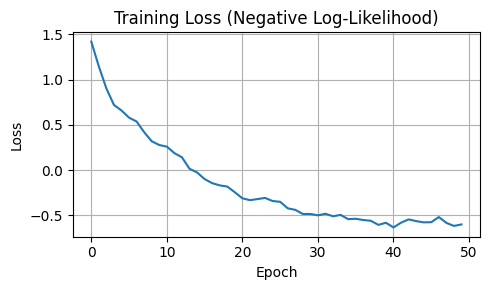

In [ ]:
# Plot training progress
plt.figure(figsize=(5, 3))
plt.plot(losses)
plt.title("Training Loss (Negative Log-Likelihood)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.tight_layout()
plt.show()

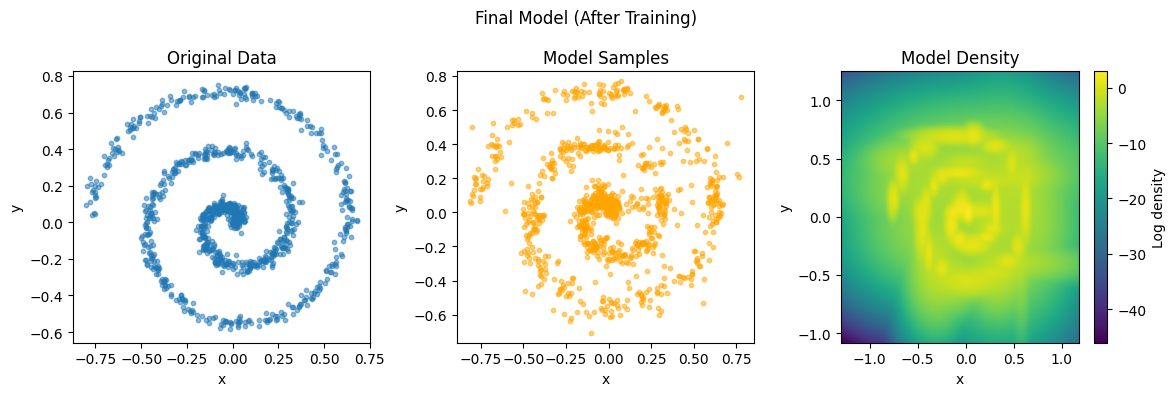

In [ ]:
# Show final results
plot_data_and_model(data, gmm, "Final Model (After Training)")